# Single cell RNA-seq analysis 
Zeal Jinwala <br>
Date: May 31, 2022 <br>
Dataset: The data corresponds to an experiment where RNA was sequenced from many single cells in a population. Rows correspond to genes.  Columns correspond to cells.  Values correspond to the counts of a given gene in a given cell. It contains a matrix of 14131 features (rows) measured across 123 samples.

### Import required libraries

In [7]:
import os
import pandas as pd
import scanpy as sc

In [8]:
# scanpy config
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.20.2 scipy==1.7.3 pandas==1.2.3 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.10 pynndescent==0.5.7


## Load data

In [9]:
results_file = 'pbmc3k.h5ad'
# reading data
INPUT_FILE_PATH = os.path.join(os.getcwd(), "scRNAseqDataset.txt")
adata = sc.read_text(INPUT_FILE_PATH).transpose()
adata.var_names_make_unique()

## Preprocessing

### View/examine data

normalizing counts per cell
    finished (0:00:00)


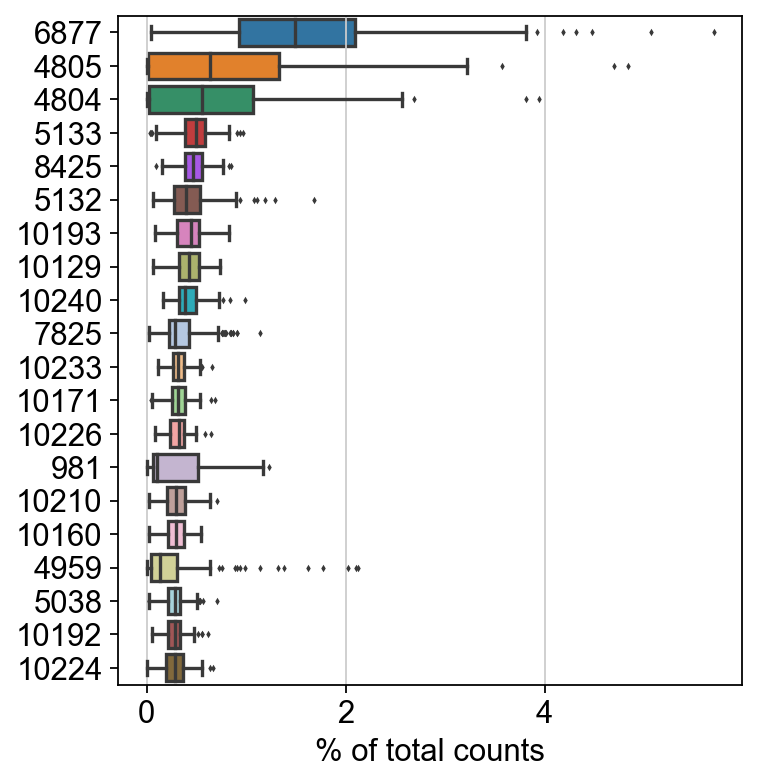

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Calculate and visualize metrics

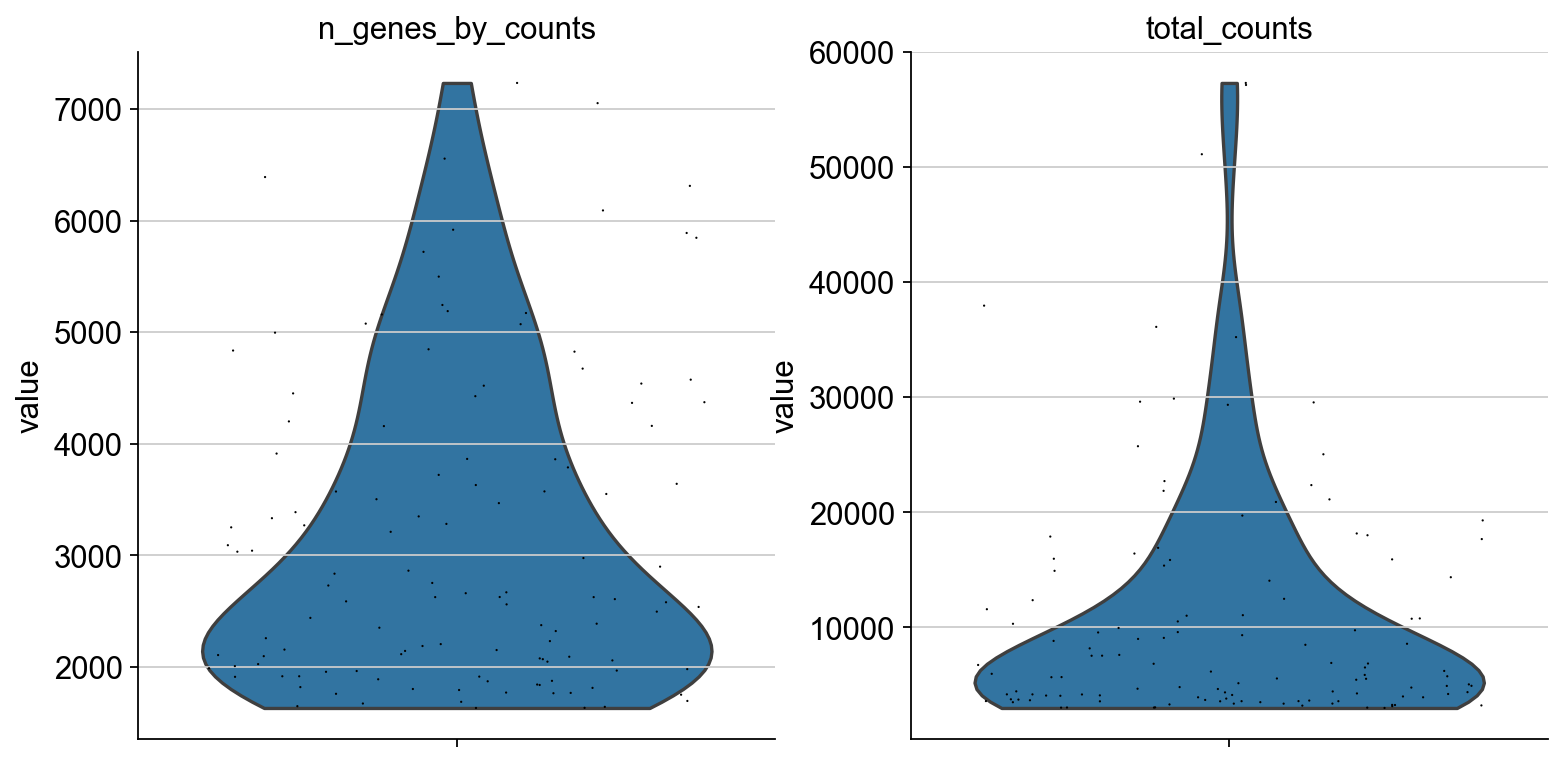

In [11]:
sc.pp.calculate_qc_metrics(adata, var_type = 'genes', percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

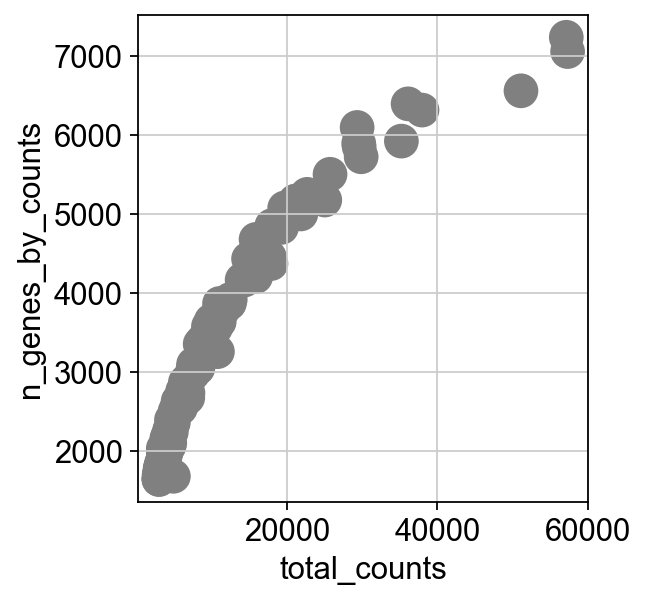

In [12]:

sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

### Actually filter based on metrics calculated and Normalize

In [13]:
adata = adata[adata.obs.n_genes_by_counts < 5500, :]
sc.pp.normalize_total(adata, target_sum=1e4, inplace=True)

normalizing counts per cell
    finished (0:00:00)


/Users/zsj24/Library/Python/3.8/lib/python/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


### Log-transform

In [14]:
sc.pp.log1p(adata)

### View and filter highly variable genes

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


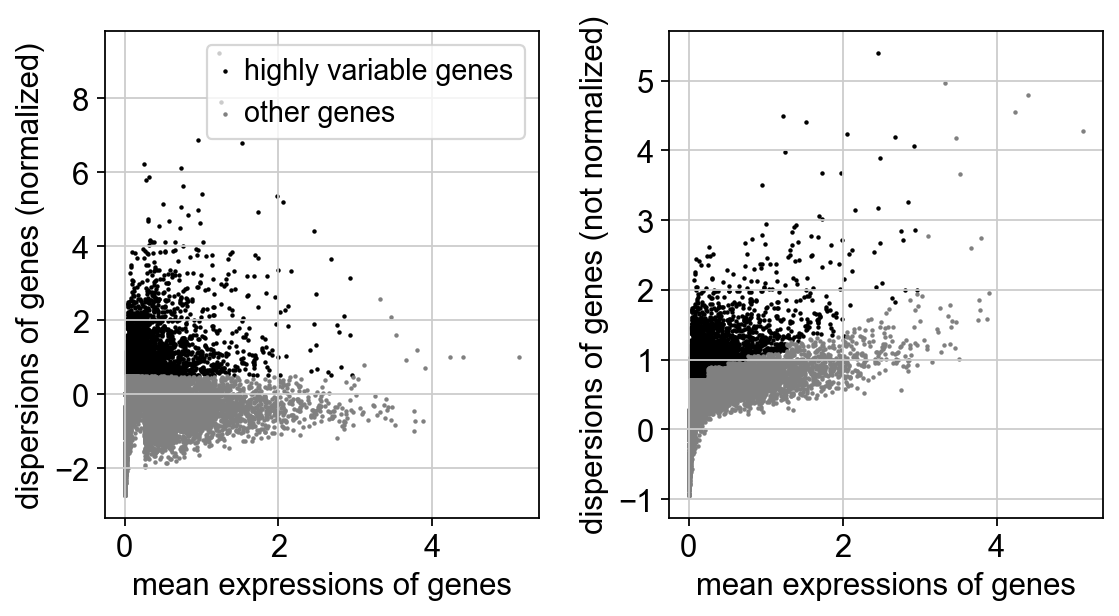

In [15]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]

### Scale the data

In [16]:
sc.pp.scale(adata, max_value=10)

/Users/zsj24/Library/Python/3.8/lib/python/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Principle Component Analysis

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


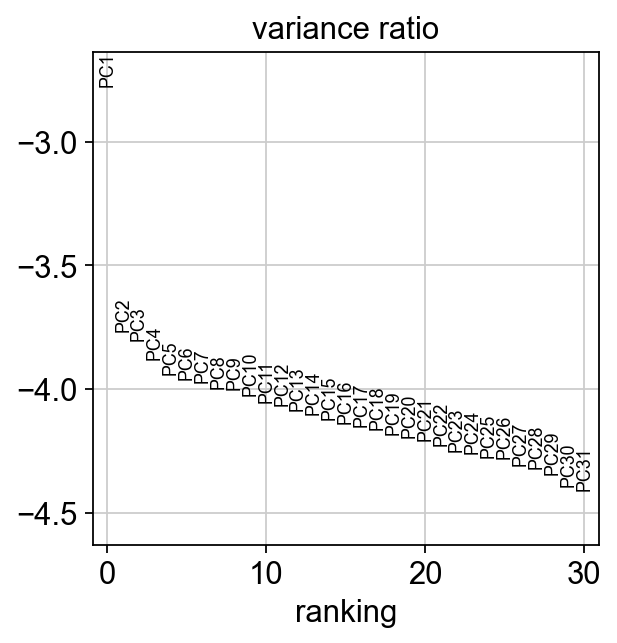

In [17]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
adata.write(results_file)

## Computing the neighborhood graph

In [18]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)


computing neighbors
    using 'X_pca' with n_pcs = 10
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)


## Embedding the neighborhood graph

In [19]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


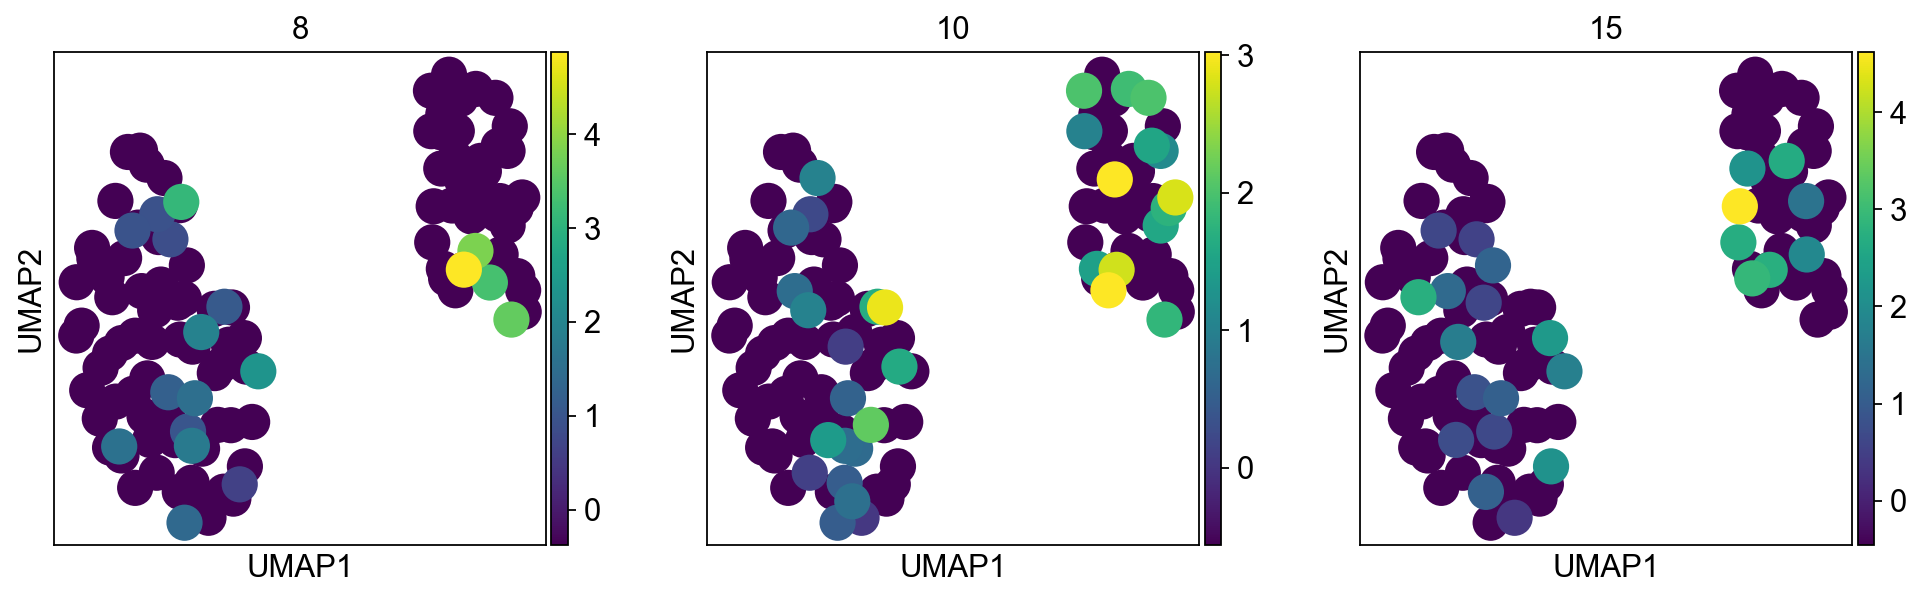

In [20]:
sc.pl.umap(adata, color=['8', '10','15'])

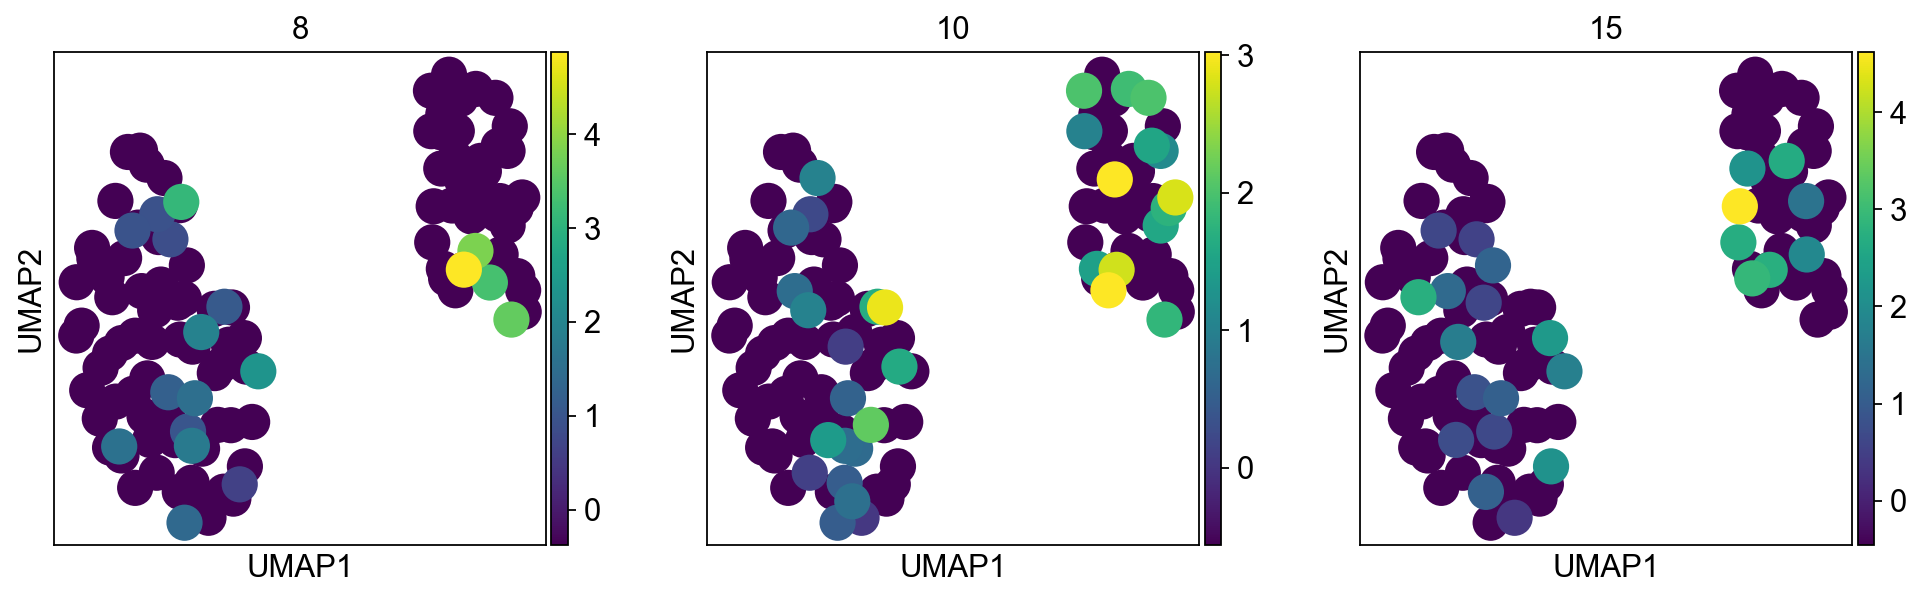

In [21]:
sc.pl.umap(adata, color=['8', '10','15'], use_raw=False)

## Clustering the neighborhood graph

In [22]:
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


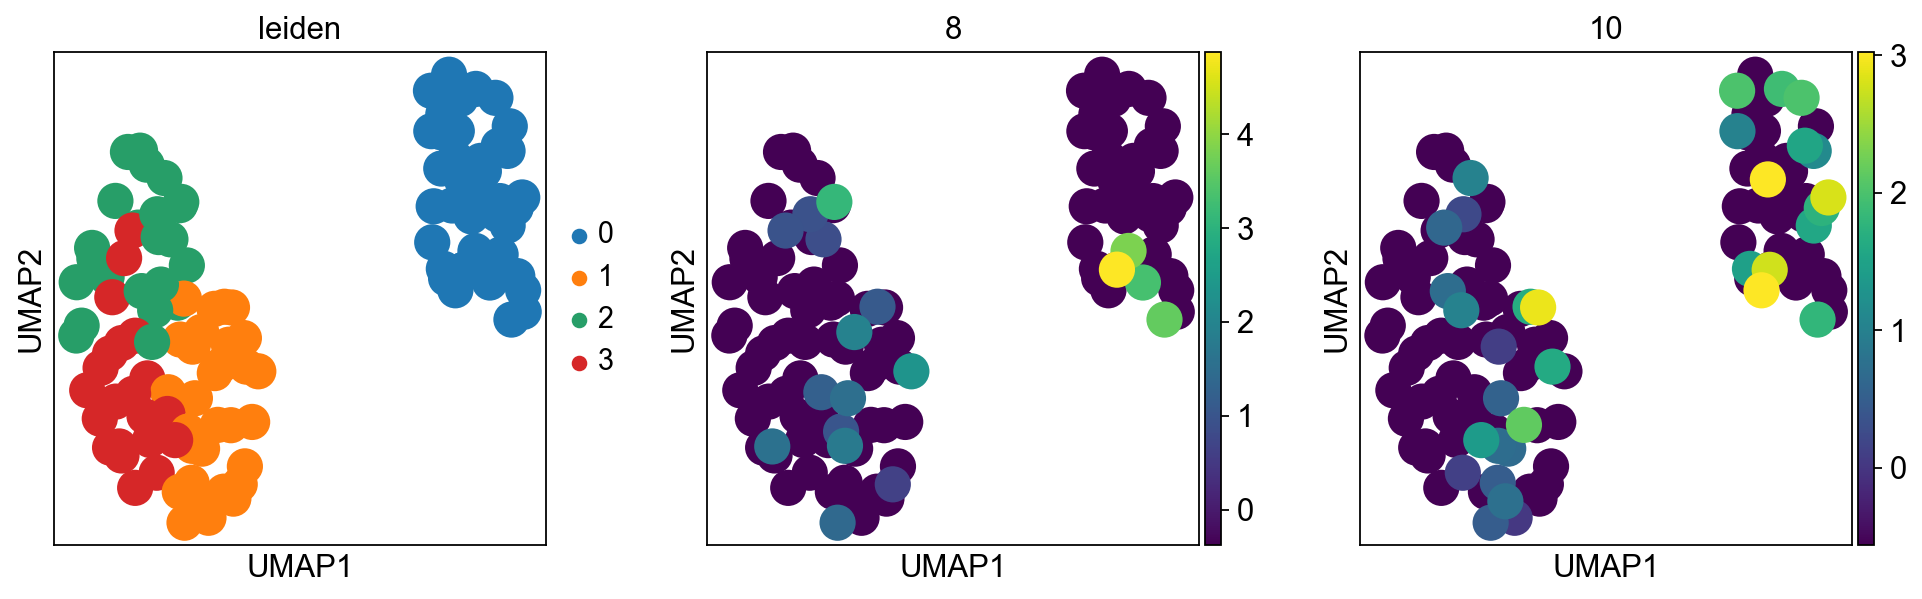

In [23]:
sc.pl.umap(adata, color=['leiden', '8', '10'])
adata.write(results_file)

## Finding marker genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/Users/zsj24/Library/Python/3.8/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


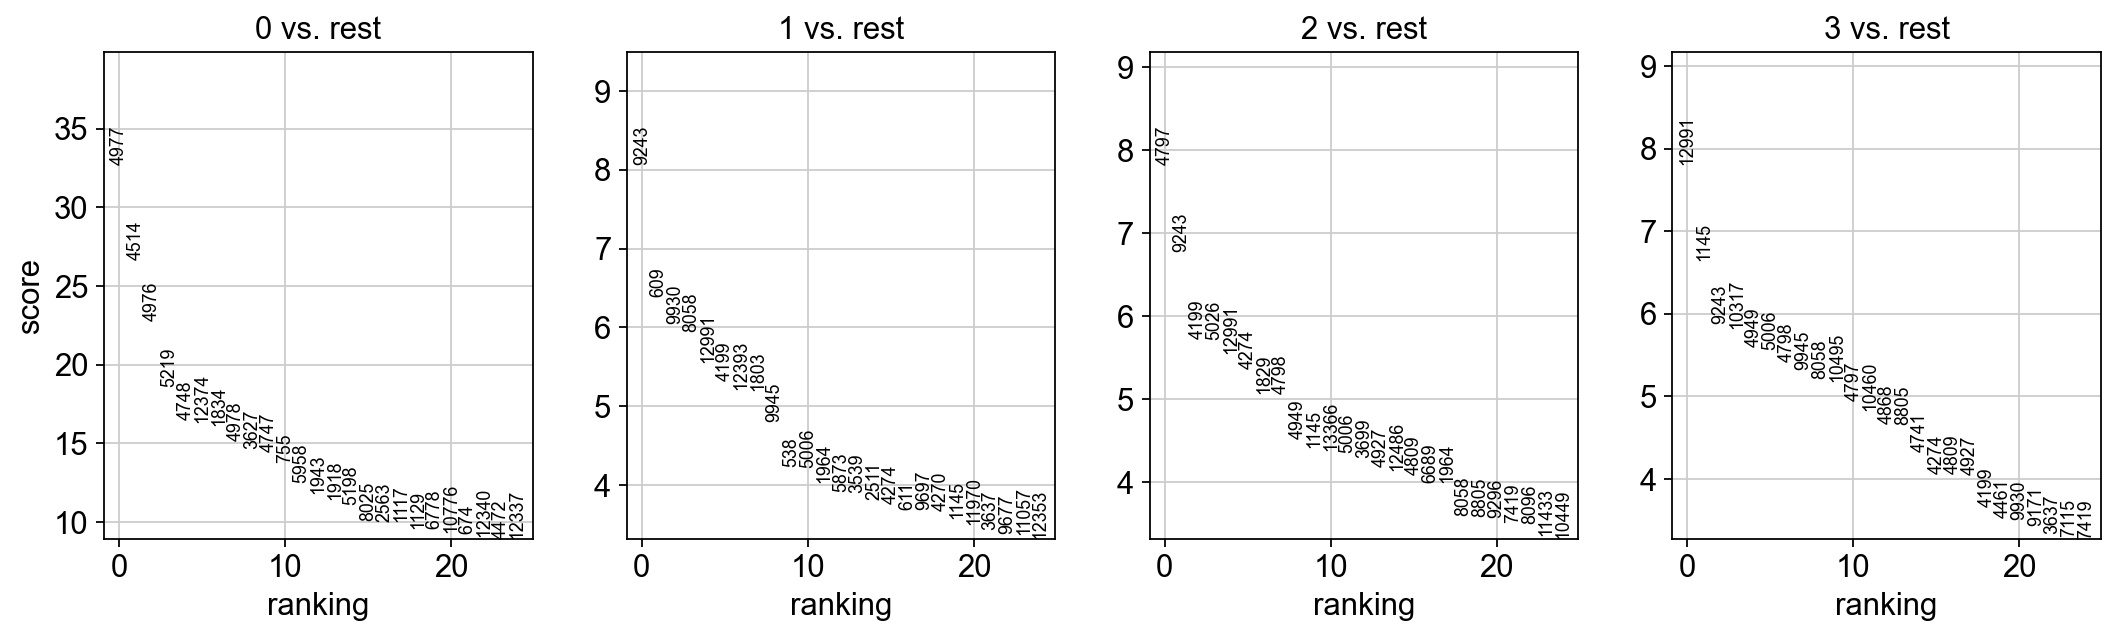

In [24]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/Users/zsj24/Library/Python/3.8/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


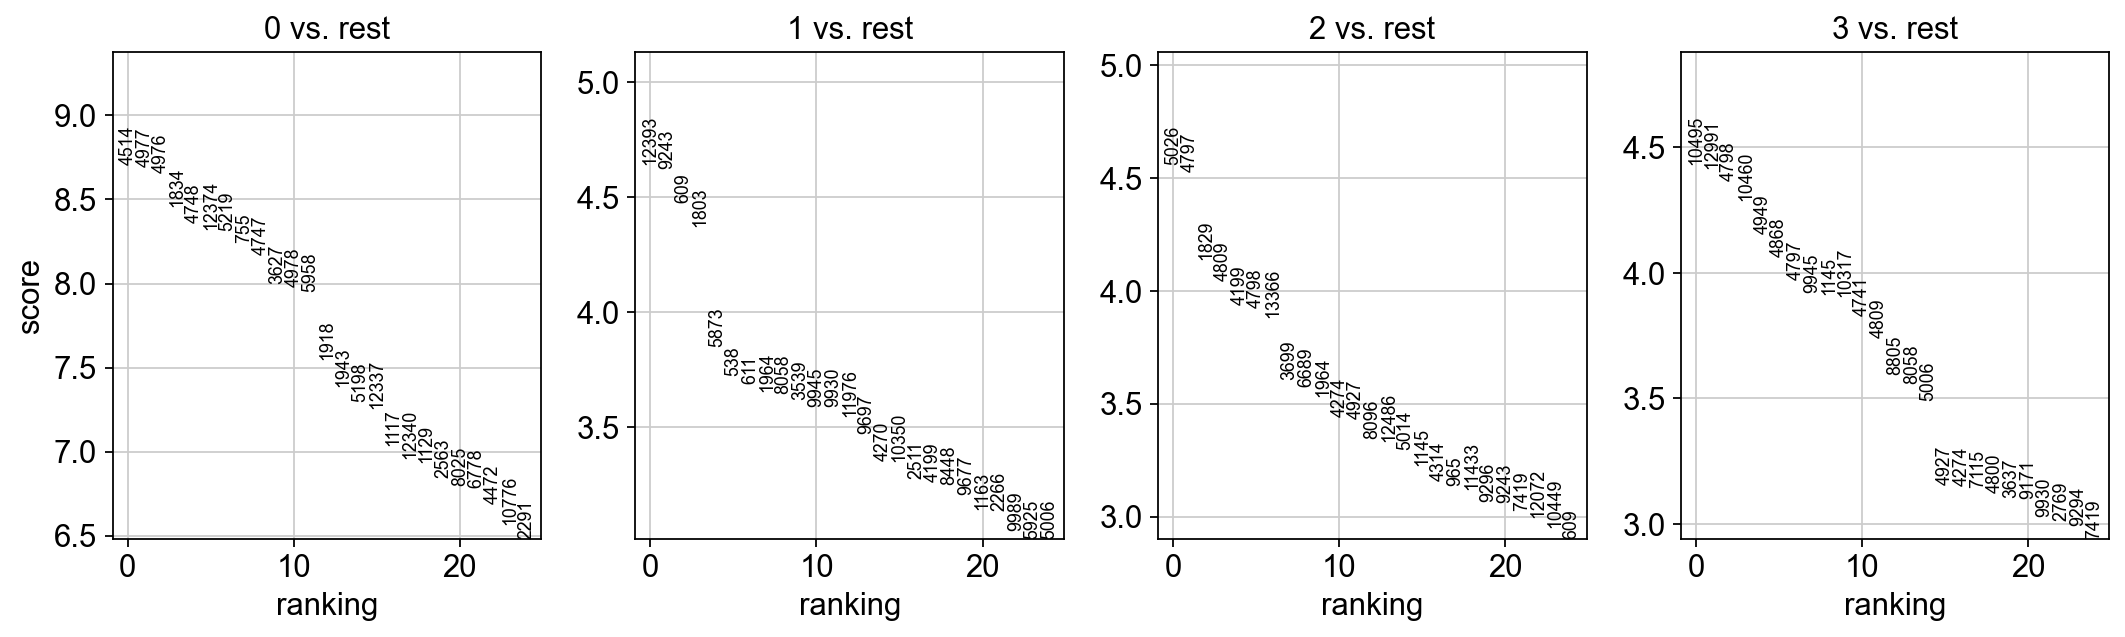

In [25]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [26]:
adata.write(results_file)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:00)


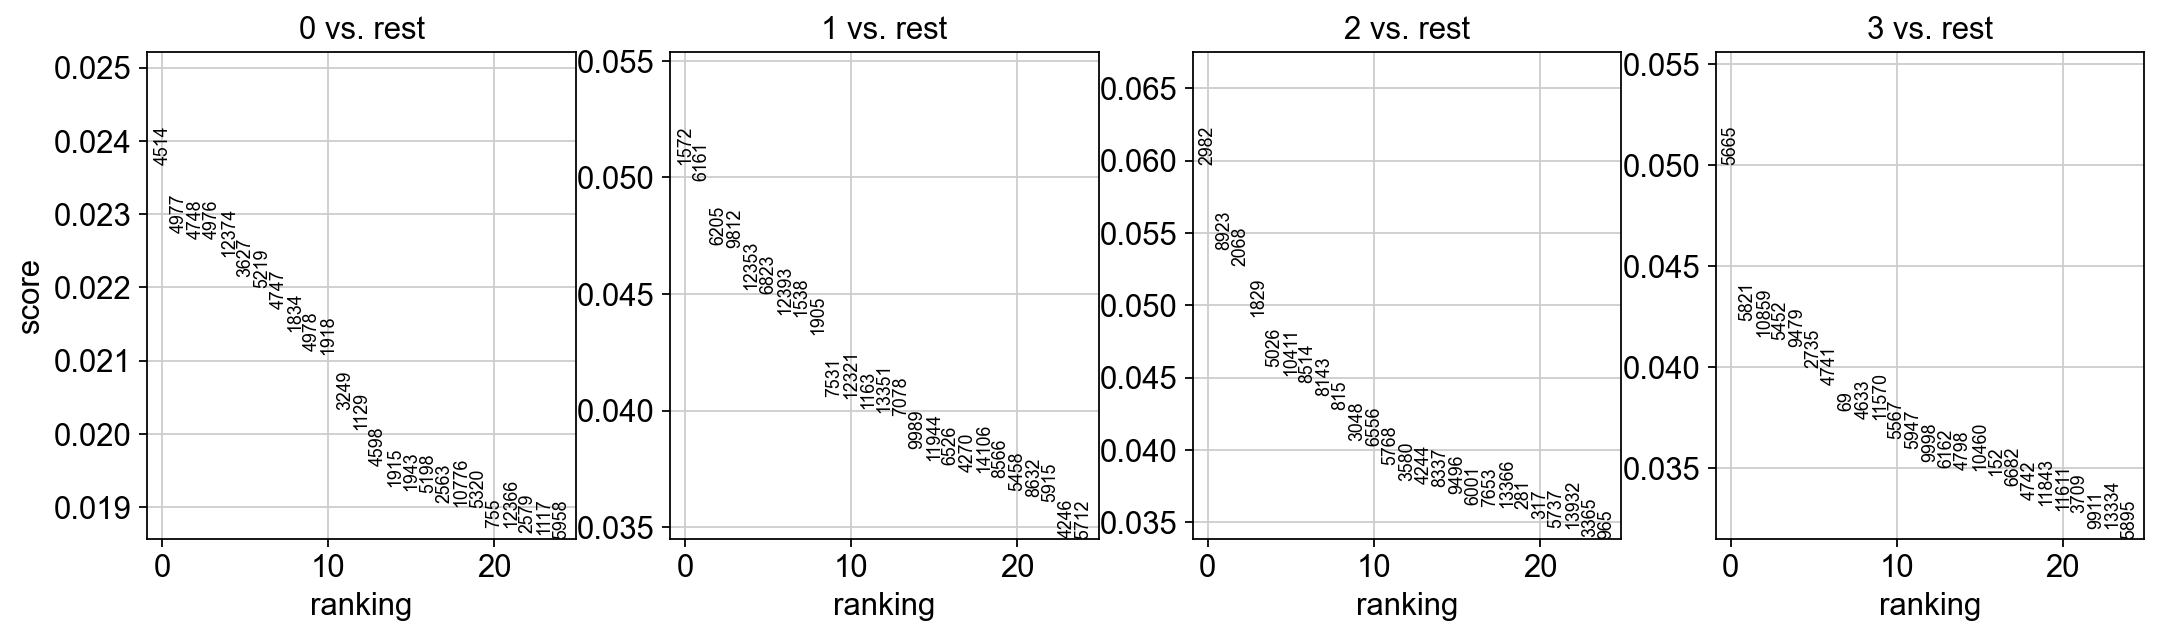

In [27]:
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [28]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

,0,1,2,3
0,4514,1572,2982,5665
1,4977,6161,8923,5821
2,4748,6205,2068,10859
3,4976,9812,1829,5452
4,12374,12353,5026,9479


### alternative methods to rank genes

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/Users/zsj24/Library/Python/3.8/lib/python/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


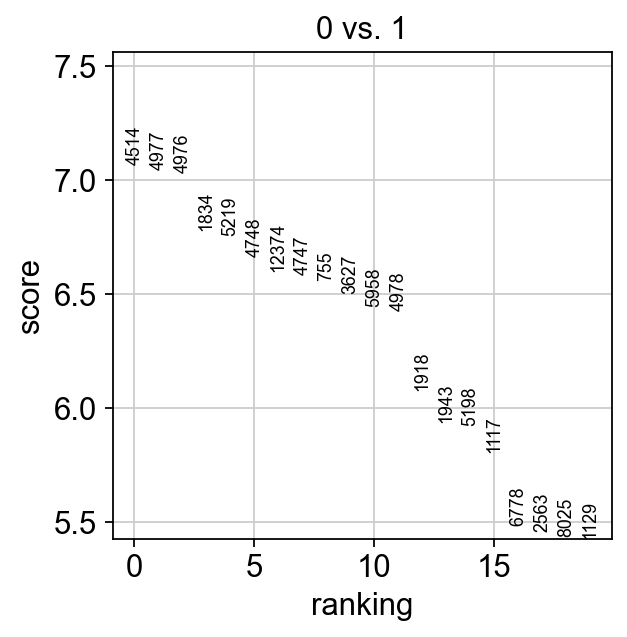

In [29]:
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

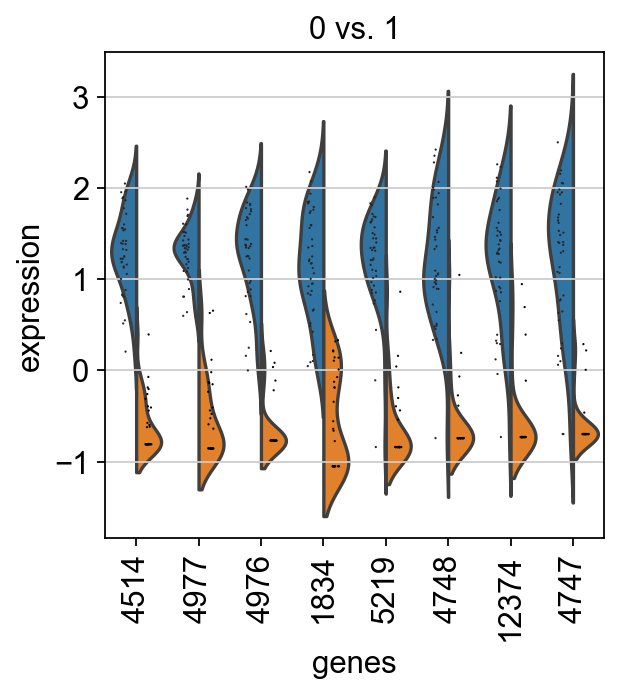

In [30]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

In [31]:
adata = sc.read(results_file)

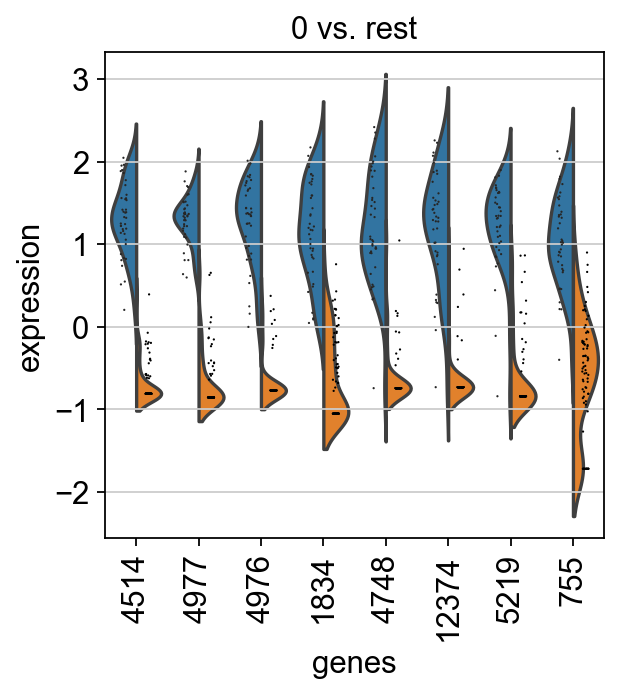

In [32]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

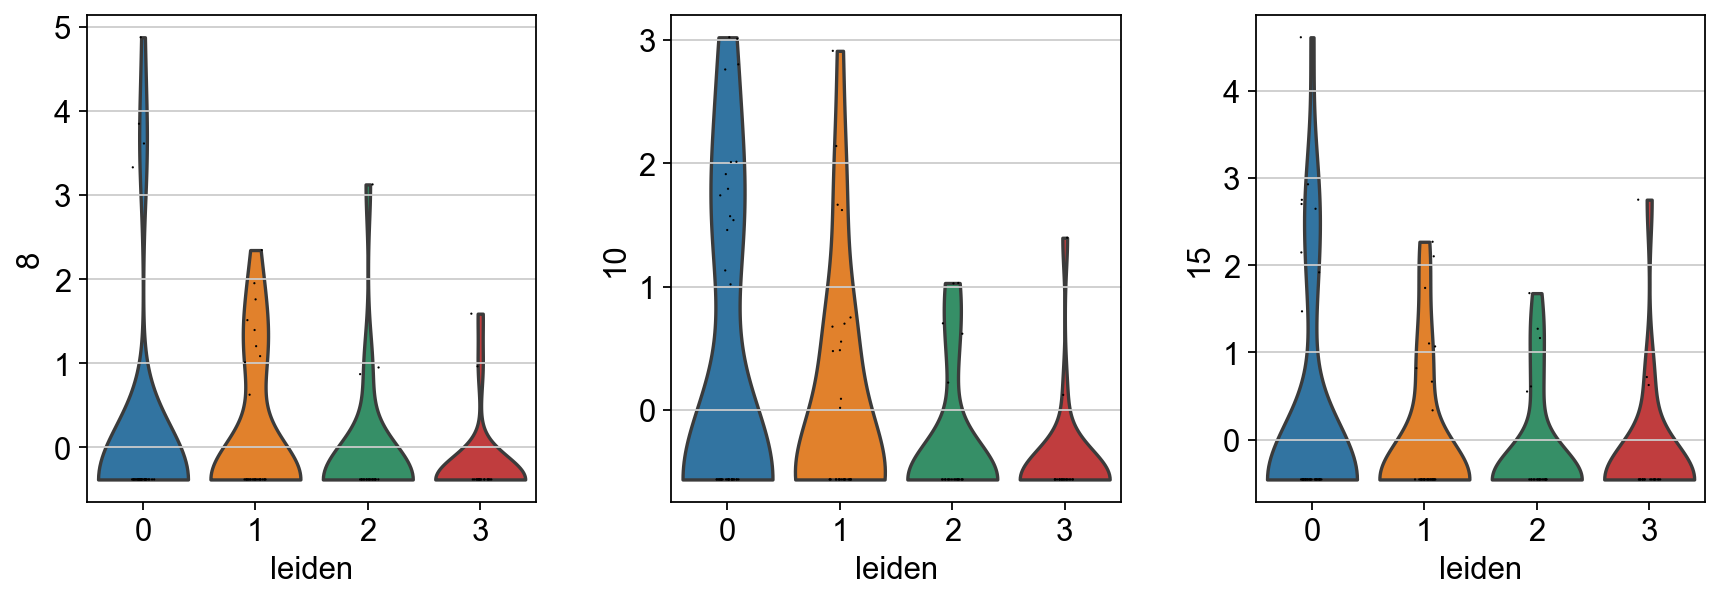

In [33]:
sc.pl.violin(adata, ['8', '10','15'], groupby='leiden')

### Identify clusters

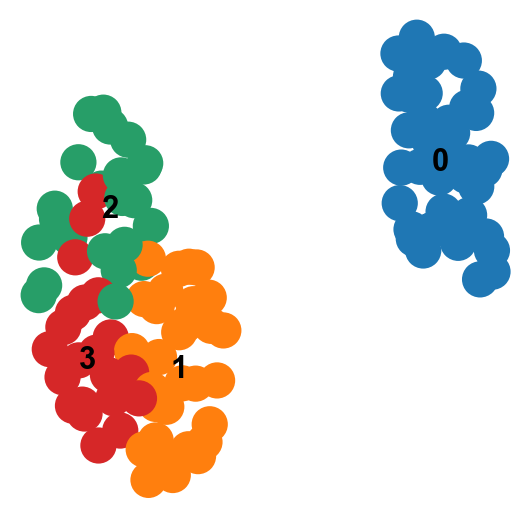

In [34]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')